# Hypothesis Testing 

The big idea of a hypothesis test is to check whether an observed effect is something that can be explained just to to chance, or **sampling error**. We are looking at only a sample from a larger population, and there will be variability from sample to sample. Is the observed effect within the normal variability or is it more extreme and cannot be attributed just due to chance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Oftentimes, you will be testing to see if there is a difference between two populations. For example, you might wonder if there is a difference in the distribution of time spent sleeping for females compared to males.

We'll start with the assumption that there is no difference in distributions for males and females. This is what is known as the **null hypothesis**. Our **alternate hypothesis** is that there is a difference in distributions.

Then, we'll look at the data and see if what we observe is in line with that null hypothesis or if it would be unlikely under the null hypothesis.

## Method 1: Permutation Testing

**Big Idea:** If the null hypothesis is true and there is no difference in the distribution of sleep times for males and females, then we could shuffle the male/female labels and still have a valid sample.

So, the procedure that we'll use is to compare our actual sample to the collection of samples we can obtain by shuffling labels.

How do we compare? We have to choose some test statistic. For example, we'll use the absolute value of the difference in mean sleeping time for male participants and mean sleeping time for female participants. 

We'll then check what proportion of permuted samples have a larger difference means. This proportion is the **p-value** for the test. A small p-value would mean a highly unusual sample if the null hypothesis were true.

Before running the test, we have to determine how unusual a sample would be too unusual. This is known as the **significance level** for the test. A common significance level is 0.05, and that's what we'll use here.

In [2]:
sleeping = pd.read_csv('../data/atus_sleeping.csv')
sleeping.head()

,participant_id,minutes_spent_sleeping,sex
0,20181211181182,270,Male
1,20180908180663,600,Male
2,20180706181412,355,Male
3,20181009181978,405,Male
4,20180503180964,270,Male


In [3]:
sleeping.groupby('sex')['minutes_spent_sleeping'].mean()

sex
Female    582.32
Male      519.60
Name: minutes_spent_sleeping, dtype: float64

If we want to translate this to a difference, we can use the `diff` method, and we'll also use `abs` to compute the absolute value.

In [4]:
observed_test_statistic = sleeping.groupby('sex')['minutes_spent_sleeping'].mean().diff().abs().iloc[1]
observed_test_statistic

np.float64(62.72000000000003)

Now, let's generate 10000 permutations of our data. We need to sample without replacement this time, so we need to do this using a list comprehension.

A **list comprehension** is a condensed way of writing a for loop.

In [5]:
cubes = []
for x in [1, 3, 5]:
    cubes.append(x**3)

cubes

[1, 27, 125]

Instead of writing this across multiple lines, I could do it all in one.

In [6]:
cubes = [x**3 for x in [1, 3, 5]]
cubes

[1, 27, 125]

Let's see how we can use a list comprehension to generate our permutations.

In [7]:
num_permutations = 10000

permutations = np.array([np.random.choice(
    sleeping['minutes_spent_sleeping'], 
    len(sleeping['minutes_spent_sleeping']), 
    replace=False) 
                         for i in range(num_permutations)])

Now, we want to calculate the difference in means between the male group and female group. To do this we can slice our permutations using the number of males.

A quick note about slicing a numpy array. Similar to slicing a list, we can specify how many elements we want to keep. If we are working with a one-dimensional array, it functions the same as slicing a list, but for a 2-dimensional array, we need to specify how many rows and how many columns we want to keep.

In [8]:
my_array = np.array([['a', 'b', 'c'], ['d', 'e', 'f'], ['g', 'h', 'i'], ['j', 'k', 'l']])
my_array

array([['a', 'b', 'c'],
       ['d', 'e', 'f'],
       ['g', 'h', 'i'],
       ['j', 'k', 'l']], dtype='<U1')

To select some number of rows, the selection looks similar to slicing a list. We can specify a starting row (remember that Python starts counting at 0) and then an ending row. Slicing includes the first row but does not include the last.

In [9]:
my_array[1:3]

array([['d', 'e', 'f'],
       ['g', 'h', 'i']], dtype='<U1')

If we want to select column, we can do it simiarly, but we do it after a comma.

In [10]:
my_array[1:3, 1:3]

array([['e', 'f'],
       ['h', 'i']], dtype='<U1')

We can also slice all the way to the end or from the beginning by omitting a number.

In [11]:
my_array[1:, :2]

array([['d', 'e'],
       ['g', 'h'],
       ['j', 'k']], dtype='<U1')

Or we can keep all by omitting both numbers.

In [12]:
my_array[:, 1:]

array([['b', 'c'],
       ['e', 'f'],
       ['h', 'i'],
       ['k', 'l']], dtype='<U1')

Back to our permutations, we want to keep all rows but just enough columns for the male participants.

In [13]:
num_males = sleeping['sex'].value_counts()['Male']

permutation_differences = np.abs(permutations[:,:num_males].mean(axis=1) - permutations[:,num_males:].mean(axis=1))

Now, let's see where our observed statistic lands compared to the permuted stats.

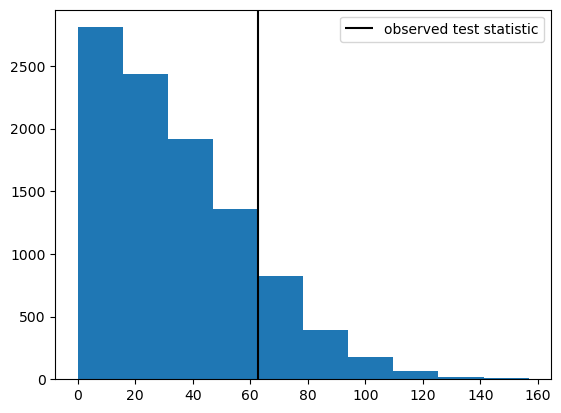

In [14]:
plt.hist(permutation_differences)
ymin, ymax = plt.ylim()
plt.vlines(x=observed_test_statistic, ymin=ymin, ymax=ymax, color='black', label='observed test statistic')
plt.ylim(ymin, ymax)
plt.legend();

To find the p-value for this test, we need to determine the proportion of permutations that had a larger test statistic value than what we observed in our sample.

In [15]:
(np.array(permutation_differences) >= observed_test_statistic).mean()

np.float64(0.1483)

In this case, the p-value is larger than the significance level. This means that what we observed wouldn't be all that unusual if the null hypothesis were true.

**Conclusion:** The data does not provide enough evidence to conclude that there is a difference in distributions. Any observed differences could be explained by random sampling error.

To summarize what we did, here is the general procedure for conducting a hypothesis test.

**Hypothesis Testing Steps:**

1. State null and alternative hypotheses and significance level.
2. Assume that the null hypothesis is true, and choose  a statistic to calculate based on your observed values.
3. Determine/estimate how your chosen statistic is distributed under the null hypothesis
4. Find the $p$-value: how often would you see a sample statistic as extreme or more extreme than the one you observed?
5. If $p$-value is smaller than the significance level, reject the null hypothesis. Otherwise, do not reject the null hypothesis.

## Method 2: Analytical Approach - Welch's Test

For the analytical approach, we'll be a little more precise and make our hypotheses about the means of the two distributions. Let $\mu_M$ represent the average time spent sleeping by males and $\mu_F$ represent the average time spent sleeping by females.

**Null Hypothesis:**

$H_0: \mu_M = \mu_F$

**Alternative Hypothesis:**

$H_1: \mu_M \neq \mu_F$

For this and all tests in this notebook, we'll use a 0.05 significance level.

Now, we need to compute our test statistic and compare the observed test statistic to the overall distribution of that test statistic.

This method will use a fact about the distribution in the difference between sample means.

**Fact:** If both populations are approximately normally distributed, then 

$$t = \frac{\bar{x}_1 - \bar{x}_2}{s}$$ approximately follows a $t$ distribution. Here

$$s = \sqrt{\frac{s_1^2}{N_1} + \frac{s_2^2}{N_2}}$$

where $s_1$ and $s_2$ are the sample standard deviations and $N_1$ and $N_2$ are the sample sizes.

This $t$ distribution has degrees of freedom equal to 
$$df = \left(\frac{s_1^2}{n_1}+ \frac{s_2^2}{n_2}\right)^2 / \left(\frac{s_1^4}{n_1^2(n_1-1)} + \frac{s_2^4}{n_2^2(n_2-1)} \right)$$

See http://www.dcscience.net/welch-1947.pdf if you really want to see details, but I don't recommend it.

Luckily for us, this has been implemented in `scipy.stats` as `ttest_ind`.

In [16]:
from scipy.stats import ttest_ind

To use this function, you need to pass in the observed values for each group and specify that you want `equal_var = False`.

In [17]:
t_results = ttest_ind(
    sleeping.loc[sleeping.sex == 'Male', 'minutes_spent_sleeping'],
    sleeping.loc[sleeping.sex == 'Female', 'minutes_spent_sleeping'],
    equal_var = False,
    alternative="two-sided"
)
t_results

TtestResult(statistic=np.float64(-1.4803934746073193), pvalue=np.float64(0.14578885880640693), df=np.float64(44.66069504954624))

This says that if the null hypothesis is true and there is no difference in average sleeping times, you can expect to see a difference as large as what you observed more than 14% of the time. This is not particularly compelling evidence that the null is not true. You should not reject the null. There is not enough evidence to conclude that there is a difference in average sleeping times between males and females.

## Hypothesis Testing for Independence of Categorical Variables

What if we have two categorical variables and want to test if one influences the other. That is, are the variables independent or dependent.

Finally, let's look at the squirrel census data again. A lot of people have never seen a black squirrel, so me might hypothesize that black squirrels are more skittish and do not approach humans as frequently.

Let's formally state this as a null and alternative hypothesis.

**Null Hypothesis:**  
$H_0:$ The squirrel's primary fur color and likelihood of approaching are **independent**.

**Alternative Hypothesis:**   
$H_1:$ The squirrel's primary fur color and likelihood of approaching are **dependent**.

Now, let's bring in the data.

In [18]:
squirrels = pd.read_csv('../data/squirrels.csv')
squirrels = squirrels.dropna(subset=['Approaches', 'Primary Fur Color'])

Run a cross-tabulation to see how often black squirrels run compared to other colors.

In [19]:
ct = pd.crosstab(squirrels['Approaches'], squirrels['Primary Fur Color'])
ct

Primary Fur Color,Black,Cinnamon,Gray
Approaches,,,
False,97,348,2347
True,6,44,126


We can also normalize for easier comparison.

In [20]:
pd.crosstab(squirrels['Approaches'], squirrels['Primary Fur Color'], normalize='columns')

Primary Fur Color,Black,Cinnamon,Gray
Approaches,,,
False,0.941748,0.887755,0.94905
True,0.058252,0.112245,0.05095


What would it mean if the primary fur color and likeliood of running from were independent. It would mean that 
$$P(\text{Primary Fur Color }= x\text{ and Approaches }= y) = P(\text{Primary Fur Color }= x)\cdot P(\text{Approaches }= y).$$

We can use `value_counts` to see the estimated probabilites for each variable separately.

In [21]:
squirrels['Approaches'].value_counts(normalize=True).sort_index()

Approaches
False    0.940701
True     0.059299
Name: proportion, dtype: float64

In [22]:
squirrels['Primary Fur Color'].value_counts(normalize=True).sort_index()

Primary Fur Color
Black       0.034704
Cinnamon    0.132075
Gray        0.833221
Name: proportion, dtype: float64

And to get the estimated probabilities if they were independent, we can use the _outer product_.

In [23]:
np.outer(
    squirrels['Approaches'].value_counts(normalize=True).sort_index(),
    squirrels['Primary Fur Color'].value_counts(normalize=True).sort_index()
)

array([[0.03264561, 0.1242435 , 0.78381169],
       [0.00205789, 0.00783197, 0.04940933]])

In [24]:
probs_ind = pd.DataFrame(
    np.outer(
        squirrels['Approaches'].value_counts(normalize=True).sort_index(),
        squirrels['Primary Fur Color'].value_counts(normalize=True).sort_index()
    ),
    index = squirrels['Approaches'].value_counts(normalize=True).sort_index().index,
    columns = squirrels['Primary Fur Color'].value_counts(normalize=True).sort_index().index
)
probs_ind

Primary Fur Color,Black,Cinnamon,Gray
Approaches,,,
False,0.032646,0.124244,0.783812
True,0.002058,0.007832,0.049409


Let's compare it to the observed proportions.

In [25]:
pd.crosstab(squirrels['Approaches'], squirrels['Primary Fur Color'], normalize=True)

Primary Fur Color,Black,Cinnamon,Gray
Approaches,,,
False,0.032682,0.117251,0.790768
True,0.002022,0.014825,0.042453


While there isn't a perfect match, is it close enough that the difference could be attributed just to chance?

To determine this, we need a test statistic and a distribution to compare it against. The typical test statistic used in this compares the observed counts in each cell of our contingency table to the expected counts if the variables were independent.

In [26]:
expected_counts = probs_ind * ct.sum().sum()
expected_counts

Primary Fur Color,Black,Cinnamon,Gray
Approaches,,,
False,96.892183,368.754717,2326.3531
True,6.107817,23.245283,146.6469


In [27]:
ct

Primary Fur Color,Black,Cinnamon,Gray
Approaches,,,
False,97,348,2347
True,6,44,126


How do we compare our observation to the expected counts? One way is to use a **chi-squared** test statistic.

$$\chi^2 = \sum_{i,j} \frac{(observed_{i,j} - expected_{i,j})^2}{expected_{i,j}}$$

In [28]:
test_stat = ((ct - expected_counts)**2 / expected_counts).sum().sum()
test_stat

np.float64(22.791354523302328)

How unusual is this test statistic? To determine this, we need to compare it against the overall distribution of test statistics.

### Method 1: Permutation Test

We can permute one of the labels and then look at the distribution of the test statistic across a large number of permutations. 

In [29]:
num_permutations = 1000
permutation_stats = []

for _ in range(num_permutations):
    permutation = np.random.choice(
        squirrels['Approaches'], 
        len(squirrels['Approaches']), 
        replace=False)
    permutation_ct = pd.crosstab(permutation, squirrels['Primary Fur Color'])
    permutation_test_stat = ((permutation_ct - expected_counts)**2 / expected_counts).sum().sum()
    permutation_stats.append(permutation_test_stat)  

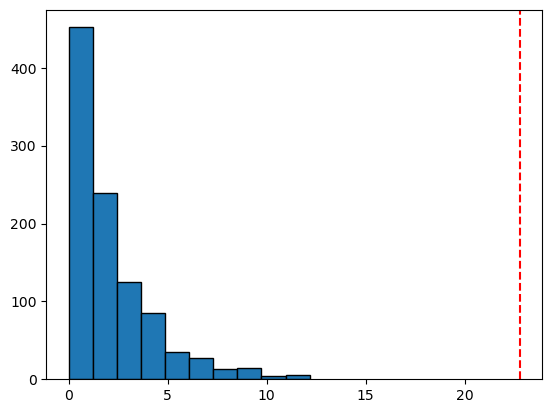

In [30]:
plt.hist(
    permutation_stats,
    edgecolor="black"
)

ymin, ymax = plt.ylim()
plt.vlines(
    x=test_stat,
    ymin=ymin,
    ymax=ymax,
    color="red",
    linestyle="--"
)
plt.ylim(ymin, ymax);

In [31]:
(np.array(permutation_stats) >= test_stat).mean()

np.float64(0.0)

In this case, we get a zero p-value. This means that what we observed would be highly unusual in the case that these variables were independent. We'll reject the null hypothesis and conclude that the fur color of a squirrel and the likelihood of it approaching are dependent.

### Method 2: Use the $\chi^2$ Distribution

For the analytical approach, we can use the following fact.

**Fact:** When the null hypothesis is true, the test statistic follows a [$\chi^2$ distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution) with degrees of freedom equal to $(r-1)\cdot(c-1)$, where $r$ and $c$ are the number of rows and columns of the contingency table, respectively.

Let's plot this distribution compared to the test statistic.

In [32]:
from scipy.stats import chi2

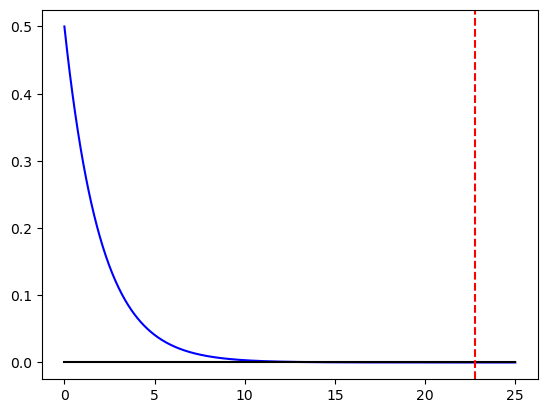

In [33]:
x = np.linspace(start=0, stop=25, num=1000)
plt.plot(
    x,
    chi2.pdf(x, df=2),
    color="blue"
)
plt.plot(
    x,
    np.zeros_like(x),
    color="black"
)
ymin,ymax = plt.ylim()
plt.vlines(
    x=test_stat,
    ymin=ymin,
    ymax=ymax,
    color="red",
    linestyle="--"
)
plt.ylim(ymin, ymax);

To find the $p$-value, we need to know how often we get a value as extreme or more extreme than the one we observed. To do this, we can use the `sf` function. The abbreviation sf stands for "survival function" which gives the probability of a value at least as large as $x$.

In [34]:
p = chi2.sf(x=test_stat, df=2)
p

np.float64(1.1243984744925015e-05)

Rather than doing all of these calculations ourself, we can also rely on the `chi2_contingency` function from scipy.stats.

In [35]:
from scipy.stats import chi2_contingency

In [36]:
chi2_contingency(ct)

Chi2ContingencyResult(statistic=np.float64(22.791354523302335), pvalue=np.float64(1.1243984744924971e-05), dof=2, expected_freq=array([[  96.89218329,  368.75471698, 2326.35309973],
       [   6.10781671,   23.24528302,  146.64690027]]))

This says that if these variables were independent, we would see such an extreme test statistic with probability 0.0000112. This is well below the significance level, meaning that we can reject the null hypothesis and conclude that primary fur color and likelihood of approaching are dependent.

## Hypothesis Testing for Correlation

Finally, what if we want to perform a test about the relationship between two numeric variables? Specifically, what if we want to test whether the correlation between two variables is nonzero.

In [37]:
nba = pd.read_csv('../data/nba_players.csv')
nba = nba.dropna()
nba.head()

,last_name,first_name,team,position,height_inches,weight_lbs,pts_per_game,rebounds_per_game,assists_per_game,salary
0,Achiuwa,Precious,Toronto Raptors,F,80,225.0,9.2,6.0,0.9,2840160
1,Adams,Steven,Memphis Grizzlies,C,83,265.0,8.6,11.5,2.3,17926829
2,Adebayo,Bam,Miami Heat,C-F,81,255.0,20.4,9.2,3.2,30351780
3,Agbaji,Ochai,Utah Jazz,G,77,215.0,7.9,2.1,1.1,3918360
4,Aldama,Santi,Memphis Grizzlies,F-C,84,215.0,9.0,4.8,1.3,2094240


Let's look at the height of a player and the points they score per game. We have a small observed correlation, but will it hold up to a hypothesis test?

In [38]:
r = nba[['height_inches', 'pts_per_game']].corr().iloc[0,1]
r

np.float64(-0.052924263324590895)

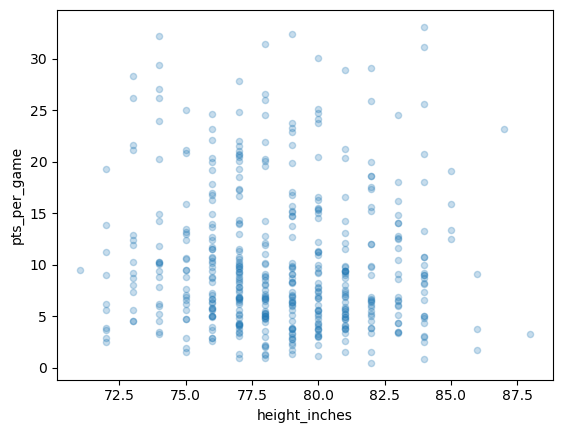

In [39]:
nba.plot(x='height_inches', y='pts_per_game', kind='scatter', alpha=0.25);

Let's formally state this as a null and alternative hypothesis.

**Null Hypothesis:**  
$H_0:$ There is zero correlation between height and points per game.

**Alternative Hypothesis:**   
$H_1:$ There is a non-zero correlation between height and points per game.

### Method 1: Permutation

In this case, we'll ranomly shuffle the points per game variable and see what the corresponding distribution of correlation values looks like.

In [40]:
num_permutations = 10000

permutations = np.array([np.random.choice(
    nba['pts_per_game'], 
    len(nba['pts_per_game']), 
    replace=False) 
                         for i in range(num_permutations)])

The numpy corrcoef function allows us to compute the correlations all at once.

In [41]:
permutation_correlations = np.abs(np.corrcoef(nba['height_inches'], permutations)[0, 1:])

Then we can see where our correlation lands compared to the distribution of correlations for the permuted values.

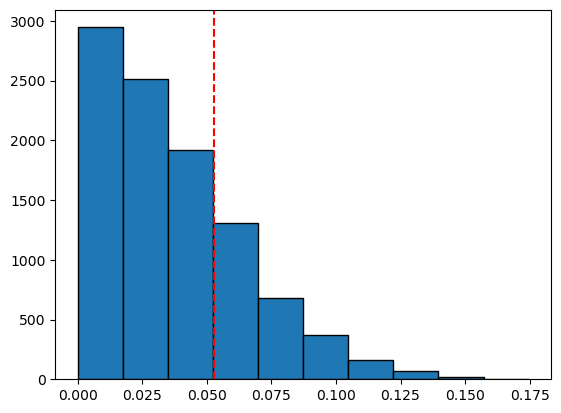

In [42]:
plt.hist(
    permutation_correlations,
    edgecolor="black"
)

ymin, ymax = plt.ylim()
plt.vlines(
    x=abs(r),
    ymin=ymin,
    ymax=ymax,
    color="red",
    linestyle="--"
)
plt.ylim(ymin, ymax);

In [43]:
(permutation_correlations >= np.abs(r)).mean()

np.float64(0.2553)

Getting this p-value, we don't have enough evidence to conclude that there is a non-zero correlation between height and points scored per game. Any observed correlation can be attributed to chance sampling error.

### Method 2: Use the $t$-Distribution

We can use $$t = \frac{r\cdot\sqrt{n-2}}{\sqrt{1-r^2}}$$

as our test statistic, where $r$ is the observed correlation and $n$ is the sample size. If the null is true, this will follow a $t$ distribution with $n-2$ degrees of freedom. (Reference: https://online.stat.psu.edu/stat500/lesson/9/9.4/9.4.1)

In [44]:
r = nba[['height_inches', 'pts_per_game']].corr().iloc[0,1]
n = nba.shape[0]
print(r, n)

-0.052924263324590895 460


In [45]:
observed_t = r * np.sqrt(n-2) / np.sqrt(1 - r**2)
observed_t

np.float64(-1.1342182698765355)

In [46]:
from scipy.stats import t

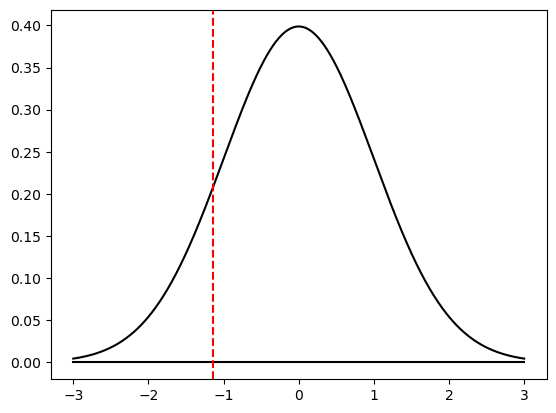

In [47]:
x = np.linspace(start=-3, stop=3, num=1000)
plt.plot(
    x,
    t.pdf(x, df=n-2),
    color="black"
)
plt.plot(
    x,
    np.zeros_like(x),
    color="black"
)
ymin,ymax = plt.ylim()
plt.vlines(
    x=observed_t,
    ymin=ymin,
    ymax=ymax,
    color="red",
    linestyle="--"
)
plt.ylim(ymin, ymax);

In [48]:
2*t.cdf(observed_t, df=n-2)

np.float64(0.2572962975311413)

We can also let scipy stats do the hard work for us.

In [49]:
from scipy.stats import pearsonr

In [50]:
pearsonr(
    x=nba['height_inches'],
    y=nba['pts_per_game']
)

PearsonRResult(statistic=np.float64(-0.0529242633245907), pvalue=np.float64(0.2572962975311429))

Again, since the p-value is greater than the significance level, we cannot reject the null hypothesis.